<a href="https://colab.research.google.com/github/elizabethts/DS5-kaggle-scalar-coupling/blob/master/notebooks/Chance_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# !pip install kaggle
# !mkdir .kaggle

import json
token = ''
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
    
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

!chmod 600 /root/.kaggle/kaggle.json


!kaggle competitions download -c champs-scalar-coupling

- path is now set to: {/content}
 56% 25.0M/44.5M [00:00<00:00, 77.2MB/s]
100% 44.5M/44.5M [00:00<00:00, 113MB/s] 
 45% 6.00M/13.4M [00:00<00:00, 60.3MB/s]
100% 13.4M/13.4M [00:00<00:00, 85.1MB/s]
 95% 60.0M/62.9M [00:00<00:00, 144MB/s]
100% 62.9M/62.9M [00:00<00:00, 141MB/s]
 86% 42.0M/48.7M [00:00<00:00, 66.9MB/s]
100% 48.7M/48.7M [00:00<00:00, 96.8MB/s]
 88% 76.0M/86.6M [00:00<00:00, 106MB/s] 
100% 86.6M/86.6M [00:00<00:00, 126MB/s]
  0% 0.00/5.31M [00:00<?, ?B/s]
100% 5.31M/5.31M [00:00<00:00, 85.8MB/s]
  0% 0.00/497k [00:00<?, ?B/s]
100% 497k/497k [00:00<00:00, 67.7MB/s]
  0% 0.00/9.24M [00:00<?, ?B/s]
100% 9.24M/9.24M [00:00<00:00, 83.7MB/s]
 84% 42.0M/49.8M [00:00<00:00, 92.9MB/s]
100% 49.8M/49.8M [00:00<00:00, 143MB/s] 
  0% 0.00/965k [00:00<?, ?B/s]
100% 965k/965k [00:00<00:00, 130MB/s]


In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
# !pip install category_encoders
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error
import numpy as np
import xgboost as xgb
from xgboost import XGBRegressor

In [0]:
trainval = pd.read_csv('/content/{/content}/competitions/champs-scalar-coupling/train.csv.zip')
test = pd.read_csv('/content/{/content}/competitions/champs-scalar-coupling/test.csv.zip')
structures = pd.read_csv('/content/structures.csv')

In [0]:
def merge_train_structures(train, structures):
  
  """This function is used to merge the structures dataset to the 
     original train dataset
     
     Parameters:
     ===========
	   train: train dataframe
	   structures: structures dataframe.
     
     Output:
	   ===========
	   dataframe: merged dataframe
     """
  
  structures = structures.rename({'atom_index': 'atom_index_0',
                                  'x':'x_0', 'y':'y_0', 'z':'z_0',
                                  'atom':'atom_0'}, axis=1)
  
  merged = pd.merge(train, structures, on=['molecule_name', 'atom_index_0'])
  
  structures = structures.rename({'atom_index_0': 'atom_index_1',
                                  'x_0':'x_1', 'y_0':'y_1', 'z_0':'z_1',
                                  'atom_0':'atom_1'}, axis=1)
  
  merged_1 = pd.merge(merged, structures, on=['molecule_name', 'atom_index_1'])
  
  structures = structures.rename({'atom_index_1': 'atom_index',
                                  'x_1':'x', 'y_1':'y', 'z_1':'z',
                                  'atom_1':'atom'}, axis=1)
  
  assert train.shape[0] == merged.shape[0]
  
  return merged_1

In [0]:
merged = merge_train_structures(trainval, structures)

In [0]:
def fe(merged):
  merged['dihedral_angle'] = abs(merged['x_0'] * merged['x_1'] + merged['y_0'] * merged['y_1'] + merged['z_0'] * merged['z_1']) / (np.sqrt(np.square(merged['x_0']) + np.square(merged['y_0']) + np.square(merged['z_0'])) * (np.sqrt(np.square(merged['x_1']) + np.square(merged['y_1']) + np.square(merged['z_1']))))
  merged['bond'] = merged['type'].str[2:]
  merged['j_type'] = merged['type'].str[:2]
  merged['distance'] = np.power((np.power((merged['x_1'] - merged['x_0']), 2) + np.power((merged['y_1'] - merged['y_0']), 2) + np.power((merged['z_1'] - merged['z_0']), 2)), 0.5)

In [0]:
fe(merged)

In [106]:
train, val = train_test_split(merged, random_state=47)
train.shape[0] + val.shape[0] == trainval.shape[0]

True

In [0]:
groups = val['type']

def group_lmae(y_true, y_pred, groups, floor=1e-9):
  maes = (y_true - y_pred).abs().groupby(groups).mean()
  return np.log(maes.map(lambda x: max(x, floor))).mean()

In [108]:
%%time
features = ['type', 'atom_1', 'dihedral_angle', 'bond', 'j_type', 'distance']
target = 'scalar_coupling_constant'

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

y_train_log = np.log1p(y_train)

xgbr = XGBRegressor(n_estimators=100,
                    random_state=47,
                    n_jobs=-1)

encoder = OrdinalEncoder()

pipe = make_pipeline(encoder, xgbr)
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_val)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log1p
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log1p
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[22:40:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 7min 26s, sys: 562 ms, total: 7min 27s
Wall time: 4min 12s


In [109]:
group_lmae(y_val, y_pred, groups)

0.8330879623968482

In [110]:
importances = xgbr.feature_importances_.astype(float)
features = X_train.columns
importances

array([5.63773513e-03, 0.00000000e+00, 2.35703032e-04, 0.00000000e+00,
       9.89502609e-01, 4.62398864e-03])

In [111]:
print(features.shape)
print(importances.shape)

(6,)
(6,)


<BarContainer object of 6 artists>

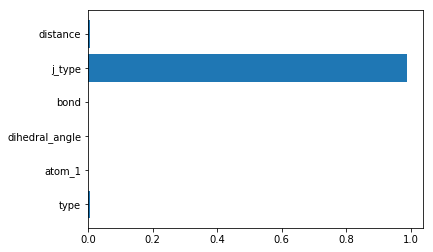

In [112]:
plt.barh(features, importances)

In [0]:
test_merged = merge_train_structures(test, structures)

In [0]:
fe(test_merged)

In [120]:
test_merged.head()

,id,molecule_name,atom_index_0,atom_index_1,type,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,dihedral_angle,bond,j_type,distance
0,4658147,dsgdb9nsd_000004,2,0,2JHC,H,-1.661639,0.0,1.0,C,0.599539,0.0,1.0,0.001673,HC,2J,2.261178
1,4658150,dsgdb9nsd_000004,3,0,1JHC,H,1.661639,0.0,1.0,C,0.599539,0.0,1.0,0.882821,HC,1J,1.062099
2,4658148,dsgdb9nsd_000004,2,1,1JHC,H,-1.661639,0.0,1.0,C,-0.599539,0.0,1.0,0.882821,HC,1J,1.062099
3,4658151,dsgdb9nsd_000004,3,1,2JHC,H,1.661639,0.0,1.0,C,-0.599539,0.0,1.0,0.001673,HC,2J,2.261178
4,4658149,dsgdb9nsd_000004,2,3,3JHH,H,-1.661639,0.0,1.0,H,1.661639,0.0,1.0,0.468233,HH,3J,3.323277


In [0]:
y_pred = pipe.predict(test_merged[features])

In [0]:
sub = ''